In [2]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
import pickle
%matplotlib inline



def collect_images(foldername):
    imglist = []
    folder = os.listdir(foldername)
    for f in folder:
        subfoldername = foldername+'/'+f
        name_pattern = subfoldername+'/*.png'
        image_files = glob.glob(name_pattern)
        for image_file in image_files:
            img = cv2.imread(image_file)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
            img = img.astype(np.float64)/255
            imglist.append(img)
    return imglist

def read_pickled_img_data(filename):
    with open(filename,'rb') as f:
        nv_data = pickle.load(f)
        v_data = pickle.load(f)
    
    return nv_data, v_data
        
#nv_imgs = collect_images('detection_data/non-vehicles')
#v_imgs = collect_images('detection_data/vehicles')
#print(np.shape(nv_imgs))
#print(np.shape(v_imgs))

#with open('img_dump.p','wb') as f:
#    pickle.dump(nv_imgs,f)
#    pickle.dump(v_imgs,f)


nv_data,v_data = read_pickled_img_data('img_dump.p')

#    print(type(nv_data))
#    print(np.shape(nv_data))
#    print()
#    print(type(v_data))
#    print(np.shape(v_data))



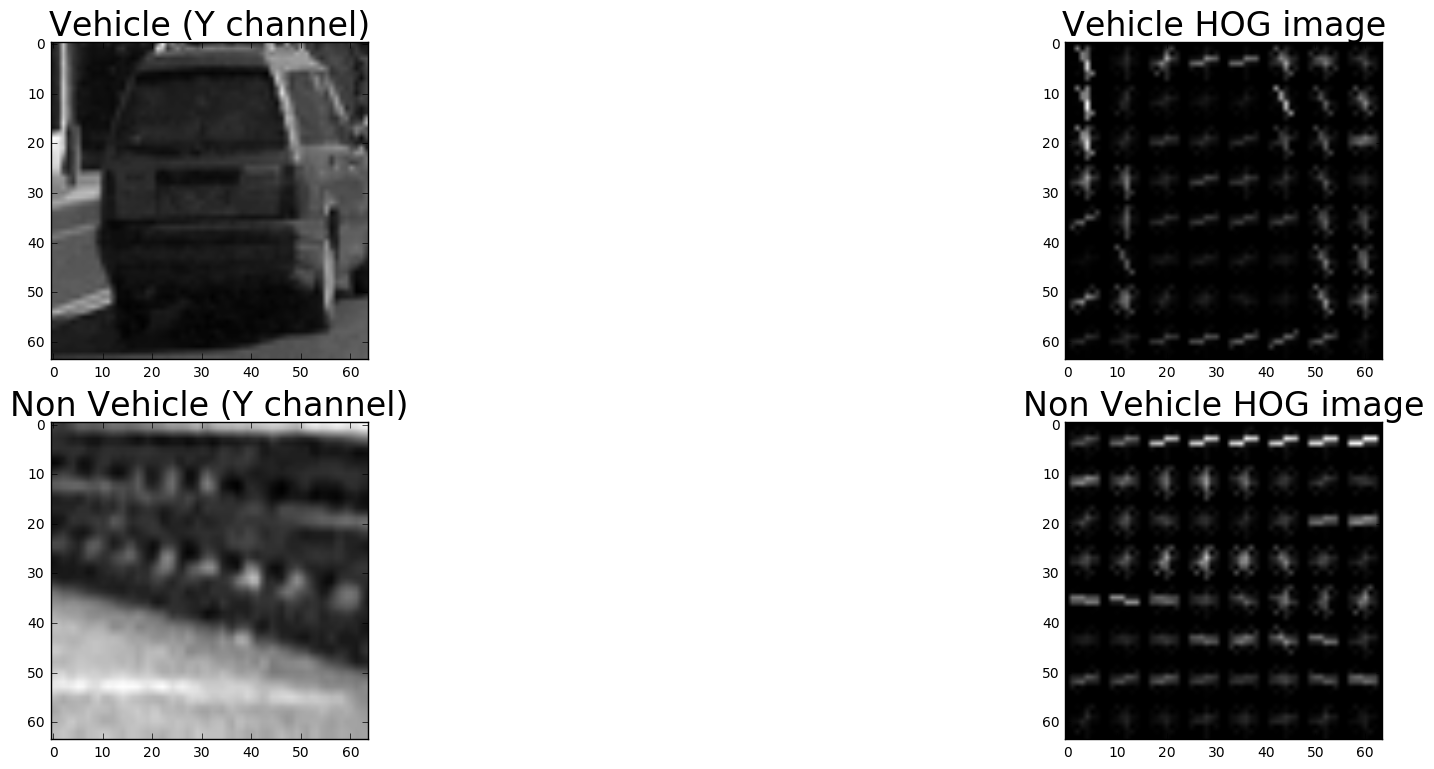

In [7]:

from feature_utils import *

nvf,nvhog = get_hog_features(nv_data[0][:,:,0], 9, 8, 2, vis=True, feature_vec=True)
vf,vhog = get_hog_features(v_data[0][:,:,0], 9, 8, 2, vis=True, feature_vec=True)

f, axarr = plt.subplots(2, 2, figsize=(24, 9))
axarr[0][0].imshow(v_data[0][:,:,0],cmap = 'gray')
axarr[0][0].set_title('Vehicle (Y channel)', fontsize=24)
axarr[0][1].imshow(vhog,cmap = 'gray')
axarr[0][1].set_title('Vehicle HOG image', fontsize=24)
axarr[1][0].imshow(nv_data[0][:,:,0],cmap = 'gray')
axarr[1][0].set_title('Non Vehicle (Y channel)', fontsize=24)
axarr[1][1].imshow(nvhog,cmap = 'gray')
axarr[1][1].set_title('Non Vehicle HOG image', fontsize=24)

In [2]:
import numpy as np
import pickle
from FeatureExtractor import *
from Classifier import *
fe = FeatureExtractor()

#nv_data,v_data = read_pickled_img_data('img_dump.p')

fe.load_data(nv_imgs,v_imgs)
fe.get_features()

print(fe.bin_spatial_sh)
print(fe.col_hist_sh)
print(fe.hog_sh)

(3072,)
(96,)
(5292,)


In [3]:
fe.get_training_testing_data()
fe.pickle_data('vd_data.p')

In [41]:
img_file = 'test_images/output_bboxes.png'
img = mpimg.imread(img_file)
im2 = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
#im2 = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
print(np.amax(im2))
print(np.amin(im2))

1.0
0.0


In [4]:
print(nv_data[0].shape)

NameError: name 'nv_data' is not defined

In [1]:

import numpy as np
import pickle
from FeatureExtractor import *
from Classifier import *
#fe = FeatureExtractor()
"""fe.load_data(nv_imgs,v_imgs)
fe.get_features()
print('non v',np.shape(nv_imgs))
print('v',np.shape(v_imgs))
print()
print('v',np.shape(fe.vehicle_features))
print('non v',np.shape(fe.non_vehicle_features))
print()
print('v',np.shape(fe.vehicle_imgs))
print('non v',np.shape(fe.non_vehicle_imgs))
fe.get_training_testing_data()
fe.pickle_data('vd_data.p')
print('train',np.shape(fe.training_features))
"""
#fe.pickle_data('vd_data.p')
classifier = Classifier()
classifier.load_data_from_pickle('vd_data.p')
#classifier.load_data_from_feature_extractor(fe)
score = classifier.train_SVM('model.p')
print()
print('score',score)


score 0.9907


In [1]:
import numpy as np
import pickle
from FeatureExtractor import *
from Classifier import *

with open('clf.p','rb') as f:
    classifier = pickle.load(f)

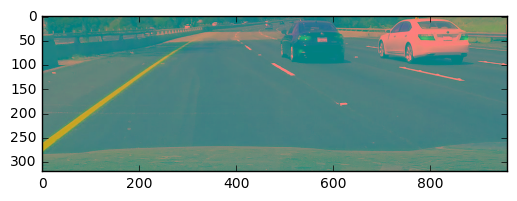

In [14]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
import pickle
%matplotlib inline
from feature_utils import *

img_file = 'test_images/test6.jpg'
img = cv2.imread(img_file)
img = img.astype(np.float32)/255
img = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)


y__img = img[400:,320:,:]

img_shape = np.shape(np.shape(y__img))
bboxes = slide_window_multiscalar(img_shape)


In [3]:
print(np.shape(bboxes))
print(y__img.shape)

(262, 2, 2)
(320, 960, 3)


In [4]:
def get_hog_features_all(feature_image,orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    hog_features = []
    for channel in range(feature_image.shape[2]):
        hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
    hog_features = np.ravel(hog_features)
    return hog_features

In [5]:
def search_classify_img(window_list,y_img,spatial_size=(32, 32),hist_bins = 32, bins_range=(0, 256)):
		hot_windows = []
		for window in window_list:
			startx = window[0][0]
			starty = window[0][1]
			endx = window[1][0]
			endy = window[1][1]

			col_img = cv2.resize(y_img[startx:endx,starty:endy],(64,64))
			hog_feats = get_hog_features_all(col_img, 9, 8, 2, 
                        vis=False, feature_vec=True)
			hog_feats = np.ravel(hog_feats)
            
			bin_spatial_feats = bin_spatial(col_img, size=spatial_size)
			col_hist_feats = color_hist(col_img, nbins=hist_bins)

			img_features = [];
			img_features.extend(bin_spatial_feats)
			img_features.extend(col_hist_feats)
			img_features.extend(hog_feats)
			score = classifier.predict(img_features)
			if(score==1):
				hot_windows.append(window)
		return hot_windows

In [15]:
#windows_list = classifier.search_classify_img(bboxes,y__img,hog_image,spatial_size=(32, 32), hist_bins=32)
windows_list = search_classify_img(bboxes,y__img,hist_bins = 32, bins_range=(0, 256))

print("hot windows",windows_list)
print()
print("count",len(windows_list))

hot windows [((25, 475), (89, 539)), ((25, 500), (89, 564)), ((0, 525), (64, 589)), ((25, 525), (89, 589)), ((0, 550), (64, 614)), ((25, 550), (89, 614)), ((25, 700), (89, 764)), ((25, 800), (89, 864)), ((25, 825), (89, 889)), ((0, 0), (96, 96)), ((0, 418), (96, 514)), ((0, 456), (96, 552)), ((0, 494), (96, 590)), ((0, 532), (96, 628)), ((38, 532), (134, 628)), ((0, 608), (96, 704)), ((0, 684), (96, 780)), ((38, 684), (134, 780)), ((0, 760), (96, 856)), ((38, 760), (134, 856)), ((38, 798), (134, 894)), ((0, 510), (128, 638)), ((0, 612), (128, 740)), ((0, 663), (128, 791)), ((0, 714), (128, 842)), ((0, 765), (128, 893)), ((0, 816), (128, 944))]

count 27


In [24]:
def search_classify_multiscale(img,clf):
	searcharea_settings = get_search_area_settings()
	multiscale_settings = get_multiscale_settings()

	windows_list = []

	orient = 9
	pix_per_cell = 8
	cells_per_block = 2
	spatial_size=(32, 32)
	hist_bins = 32

	for ms_setting in multiscale_settings:
		print(ms_setting) 
		x_start = searcharea_settings[1]+ms_setting[1][0]
		y_start = searcharea_settings[0]+ms_setting[0][0]
		x_stop = searcharea_settings[1]+ms_setting[1][1]
		y_stop = searcharea_settings[0]+ms_setting[0][1]

		scale = ms_setting[2]

		# image to search
		img_r = np.copy(img)
		img_r = img_r[y_start:y_stop,x_start:x_stop]

		if(scale!=1):
			img_r = cv2.resize(img_r,(np.int(img_r.shape[1]/scale),np.int(img_r.shape[0]/scale)))
		#ch1 = img_r[:,:,0]
		#ch2 = img_r[:,:,1]
		#ch3 = img_r[:,:,2]

		imshape = img_r.shape
		print("shape",imshape)

		# number of blocks in each image
		nx_blocks = (imshape[1]//pix_per_cell)-1
		ny_blocks = (imshape[0]//pix_per_cell)-1

		# features per block
		nfeat_per_block = (orient*cells_per_block)**2

		# window
		window = 64

		# blocks per window
		nblocks_per_window = (window//pix_per_cell)-1

		# defining overlap
		overlap_factor = 0.75
		shift_factor = 1-overlap_factor        
		cells_per_step = np.int(shift_factor*pix_per_cell) #0.75 overlap
		print("cps",cells_per_step)

		nxsteps = (nx_blocks-nblocks_per_window)//cells_per_step
		nysteps = (ny_blocks-nblocks_per_window)//cells_per_step
		print("steps",nxsteps,nysteps)

		hog_features_1 = get_hog_features(img_r[:,:,0], orient, pix_per_cell, cells_per_block, feature_vec=False)
		hog_features_2 = get_hog_features(img_r[:,:,1], orient, pix_per_cell, cells_per_block, feature_vec=False)
		hog_features_3 = get_hog_features(img_r[:,:,2], orient, pix_per_cell, cells_per_block, feature_vec=False)
		count = 0
		for xs in range(nxsteps):
			for ys in range(nysteps):
				count+=1
				print(scale)
				ypos = ys*cells_per_step
				xpos = xs*cells_per_step

				hog_sub_1 = hog_features_1[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
				hog_sub_2 = hog_features_2[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
				hog_sub_3 = hog_features_3[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()

				hog_feats = np.hstack((hog_sub_1,hog_sub_2,hog_sub_3))
				#print("hog",np.shape(hog_feats))

				x_left = xpos*np.int(pix_per_cell)
				y_top = ypos*np.int(pix_per_cell)
				x_right = x_left+np.int(window)
				y_bottom = y_top+np.int(window)
				print(x_left,x_right,y_top,y_bottom)                

				img_sub = cv2.resize(img_r[y_top:y_bottom,x_left:x_right],(64,64))

				spatial_feats = bin_spatial(img_sub,size = spatial_size)
				hist_feats =  color_hist(img_sub, nbins=hist_bins)
				#print("spatial",np.shape(spatial_feats))
				#print("hist",np.shape(hist_feats))               

				features = []
				features.extend(spatial_feats)
				features.extend(hist_feats)
				features.extend(hog_feats)
				print(count)
				#try:
				pred = clf.predict(features)
				if(pred==1):
					hot_window = ((y_top,x_left),(y_bottom,x_right))
					windows_list.append(hot_window)
					print("hot")
				#except Exception:
				#	pass
	return windows_list

In [19]:
w_list = search_classify_multiscale(img,classifier)

print("hot windows",w_list)
print()
print("count",len(w_list))

((0, 256), (0, 960), 1.5)
shape (170, 640, 3)
cps 2
steps 36 6
1.5
0 64 0 64
1
hot
1.5
0 64 16 80
2
hot
1.5
0 64 32 96
3
1.5
0 64 48 112
4
1.5
0 64 64 128
5
1.5
0 64 80 144
6
1.5
16 80 0 64
7
hot
1.5
16 80 16 80
8
1.5
16 80 32 96
9
1.5
16 80 48 112
10
1.5
16 80 64 128
11
1.5
16 80 80 144
12
1.5
32 96 0 64
13
1.5
32 96 16 80
14
1.5
32 96 32 96
15
1.5
32 96 48 112
16
1.5
32 96 64 128
17
1.5
32 96 80 144
18
1.5
48 112 0 64
19
hot
1.5
48 112 16 80
20
1.5
48 112 32 96
21
1.5
48 112 48 112
22
1.5
48 112 64 128
23
1.5
48 112 80 144
24
1.5
64 128 0 64
25
1.5
64 128 16 80
26
1.5
64 128 32 96
27
1.5
64 128 48 112
28
1.5
64 128 64 128
29
1.5
64 128 80 144
30
1.5
80 144 0 64
31
1.5
80 144 16 80
32
1.5
80 144 32 96
33
1.5
80 144 48 112
34
1.5
80 144 64 128
35
1.5
80 144 80 144
36
1.5
96 160 0 64
37
1.5
96 160 16 80
38
1.5
96 160 32 96
39
1.5
96 160 48 112
40
1.5
96 160 64 128
41
1.5
96 160 80 144
42
1.5
112 176 0 64
43
1.5
112 176 16 80
44
1.5
112 176 32 96
45
1.5
112 176 48 112
46
1.5
112 176 64 1

In [7]:
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=4):
	# Make a copy of the image
	imcopy = np.copy(img)
	# Iterate through the bounding boxes
	for bbox in bboxes:
	# Draw a rectangle given bbox coordinates
		cv2.rectangle(imcopy, (bbox[0][1],bbox[0][0]), (bbox[1][1],bbox[1][0]), color, thick)
	# Return the image copy with boxes drawn
	return imcopy

def draw_boxes2(img, bboxes, color=(0, 255, 255), thick=4):
	# Make a copy of the image
	imcopy = np.copy(img)
	# Iterate through the bounding boxes
	for bbox in bboxes:
	# Draw a rectangle given bbox coordinates
		cv2.rectangle(imcopy, bbox[1], bbox[0], color, thick)
	# Return the image copy with boxes drawn
	return imcopy

(320, 960, 3)


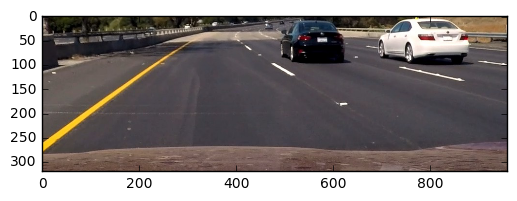

In [25]:
img_file = 'test_images/test6.jpg'
timg = mpimg.imread(img_file)
timg = timg[400:,320:,:]
plt.imshow(timg)
print(timg.shape)

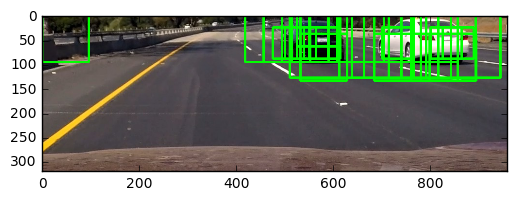

In [17]:
ret_img = draw_boxes(timg,windows_list)
plt.imshow(ret_img)

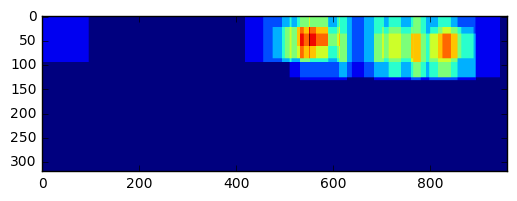

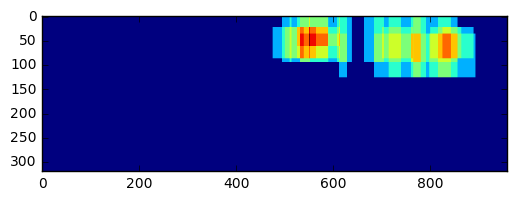

In [18]:
def add_heat(img,bbox_list):
    c_img = np.zeros_like(img[:,:,0])
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        #c_img[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        c_img[box[0][0]:box[1][0], box[0][1]:box[1][1]] += 1

    # Return updated heatmap
    return c_img

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

r_img = add_heat(timg,windows_list)
plt.imshow(r_img)

th_img = apply_threshold(r_img,2)
plt.figure()
plt.imshow(th_img)

2 cars found
((475, 0), (637, 127))
((663, 0), (892, 127))


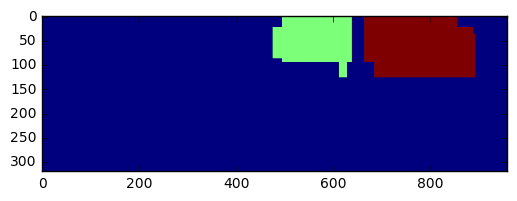

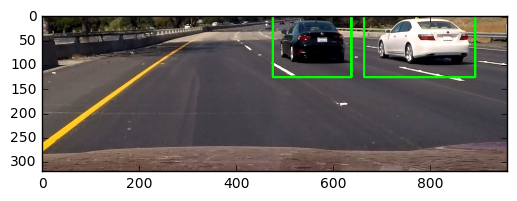

In [23]:
from scipy.ndimage.measurements import label
labels = label(th_img)

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        print(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 4)
    # Return the image
    return img

print(labels[1], 'cars found')
plt.imshow(labels[0])

draw_img = draw_labeled_bboxes(np.copy(timg), labels)
# Display the image
plt.figure()
plt.imshow(draw_img)

In [21]:
print(labels[0])

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [26]:
with open('clf.p','wb') as f:
    pickle.dump(classifier,f)

In [3]:
with open('clf.p','rb') as f:
    clf = pickle.load(f)

In [6]:
clf.load_data_from_pickle('vd_data.p')
score = clf.train_SVM('model.p')
print()
print('score',score)


score 0.9907


In [8]:
clf.load_data_from_pickle('vd_data.p')
clf.X_test = clf.scaler.transform(clf.X_test)
score = clf.classifier.score(clf.X_test,clf.y_test)
print()
print('score',score)


score 0.990709459459
